In [ ]:
# What wer're doing in this notebook (LR + BERT + MIA + LiRA)

# 1) Install and import libraries, set seeds, and detect device (CPU/GPU).
# 2) Load the EduPilot dataset and build a leak-safe text field called `text_safe`
#    by removing round names and excluding `mock_question`.
# 3) Train a TF-IDF + Logistic Regression baseline on `text_safe`
#    and record clean metrics (accuracy, log-loss).
# 4) Compute per-example losses (−log p(true)) for Logistic Regression
#    on both train (members) and test (non-members).
# 5) Prepare BERT: tokenize `text_safe`, make a small Dataset/Collator,
#    fine-tune a classifier head on top of `bert-base-uncased`, and evaluate it.
# 6) Compute per-example losses for BERT (manual batched forward pass).
# 7) Run a simple Threshold MIA (score = −loss) for both models
#    and compare ROC curves + TPR at low FPR (0.1, 0.01, 0.001).
# 8) Implement LiRA for Logistic Regression:
#    train many shadow models, collect IN vs OUT loss distributions per example,
#    fit Gaussians, and compute LLR scores.
# 9) Visualize LiRA internals:
#    (a) pick high/mid/low LLR examples and plot their IN vs OUT histograms,
#    (b) pool all IN vs OUT losses and show hist/boxplots.
# 10) Compare Threshold MIA vs LiRA (LogReg) on one plot to see
#     how LiRA improves membership detection, especially at low FPR.

# So basically, we build leak-safe text, train LR and BERT, get per-example losses,
# run Threshold MIA on both, then run LiRA on LR, and visualize/compare results.


In [ ]:
# Cell 0 — Install libraries

# Purpose: Make sure we have the exact Python packages we need for this notebook.
# Why this approach: Using pip inside the notebook is the simplest way to ensure the
# environment has the correct versions, especially in Colab or fresh kernels.
#
# Alternatives:
#   - Use a requirements.txt and `pip install -r requirements.txt`
#   - Use conda environments (more control, but heavier)
#   - Pre-baked Docker image (best for reproducibility, but more setup)

# Hugging Face stack:
# - transformers: models + Trainer API for BERT
# - datasets: (not heavily used below, but handy for future extensions)
# - accelerate: optimizes training, helps with multi-GPU (even if unused here)
# - torch: PyTorch backend (needed for BERT and tensors)
!pip -q install transformers datasets accelerate torch --upgrade

# Classical ML + visualization:
# - scikit-learn: baselines (LogReg), metrics, TF-IDF vectorizer
# - matplotlib, seaborn: plotting ROC curves etc.
# - tqdm: progress bars (optional but nice)
!pip -q install scikit-learn matplotlib seaborn tqdm

# Summary of this cell
# We installed the exact libraries our later cells depend on. This makes the rest of the
# notebook run smoothly on a fresh environment.
#
# Logic flow up to this cell
# Before this cell: nothing. This is the starting point where we prepare the environment.
# After this cell: we can safely import everything we need and start loading data.
#
# Next step (coming in Cell 1)
# Import all modules, set global configs (seeds, device), and make plotting look nice.

In [ ]:
# Cell 1 — Imports and global config

# Purpose: Bring in all libraries, set a consistent random seed, choose device (CPU/GPU),
# and set plotting style. This ensures reproducibility and nice visuals.

# Standard libraries for utilities
import os, math, random, time                   # os/env, math ops, random seeding, simple timing
from dataclasses import dataclass               # (Not used yet, but handy if we define config structs)
from typing import List, Dict, Tuple            # Type hints for readability

# Numerical + data handling
import numpy as np                              # Arrays, vectorized math
import pandas as pd                             # DataFrames for CSV

# Progress bar (useful for loops)
from tqdm import tqdm                           # Quality-of-life for training/eval loops

# Plotting
import matplotlib.pyplot as plt                 # Base plotting
import seaborn as sns                           # Prettier plots on top of matplotlib

# Scikit-learn: splits, encoding, vectorization, baselines, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

# PyTorch base + Dataset helper
import torch
from torch.utils.data import Dataset

# Hugging Face: tokenizer, model, Trainer API utilities
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# Make seaborn plots look consistent and clean.
sns.set(style="whitegrid")

# Reproducibility: set one global seed everywhere that matters.
RANDOM_SEED = 6905
def set_seed(seed=RANDOM_SEED):
    # Python's built-in RNG for things like random.shuffle
    random.seed(seed)
    # Numpy's RNG for vectorized ops
    np.random.seed(seed)
    # PyTorch RNG (CPU)
    torch.manual_seed(seed)
    # PyTorch RNG (all GPUs, if any)
    torch.cuda.manual_seed_all(seed)
    # Hash-based operations in Python can be randomized across runs; fix it
    os.environ["PYTHONHASHSEED"] = str(seed)

# Actually fix all RNGs now.
set_seed(RANDOM_SEED)

# Pick GPU if available; otherwise fall back to CPU.
# Design choice: simple ternary check keeps code concise.
# Alternative: allow user override via env var; but auto-detect is simplest for beginners.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Summary of this cell
# We imported everything, set random seeds for reproducibility, styled plots, and detected device.
#
# Logic flow up to this cell
# Cell 0 made sure all packages are installed. This cell imports them and prepares the environment
# for deterministic behavior, which is crucial for comparing attacks fairly.
#
# Next step (coming in Cell 2)
# Load the dataset from CSV, run sanity checks, and verify required columns.

Device: cpu


In [ ]:
# Cell 2 — Load dataset + sanity checks

# Purpose: Read the CSV, peek at columns/rows, verify schema, and check whether label
# words accidentally appear in the text (which would cause leakage).

# Load CSV (uploaded earlier). We assume it's in the current working directory.
df = pd.read_csv("EduPilot_dataset_2000.csv")

# Quick sanity checks to understand shape and the first few examples.
print("Columns:", list(df.columns))   # Helpful to verify expected column names
print("Rows:", len(df))               # Should be ~2000 based on description
print(df.head(5))                     # Peek at first 5 rows

# Required columns: we need 'text' (raw prompt-ish field) and 'interview_round' (label).
required = {"text", "interview_round"}
missing = required - set(df.columns)
# If any required columns are missing, immediately fail fast with a helpful message.
assert not missing, f"Missing required columns: {missing}"

# The label words we suspect could leak the label if present directly in text.
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

# Helper to detect if any label word is inside the text.
def contains_label(text):
    # Convert to string to be safe against NaNs or non-string types.
    for w in label_words:
        if w in str(text):
            return True
    return False

# Create a mask to flag rows where the text includes round names directly.
mask = df["text"].apply(contains_label)

# Show a few possibly-leaky rows to inspect (non-mutating; just a preview).
# NOTE: We don't print all because it can be noisy; here we just compute a DataFrame slice.
df.loc[mask, ["id", "text", "interview_round"]].head(10)

# Design choices
# We assert on required columns to fail early (prevent downstream cryptic errors).
# We check leakage by simple substring search. Alternatives include regex with word boundaries
#   or case-insensitive checks. For now, substring is enough because labels are distinctive.
#
# Summary of this cell
# Loaded the CSV, verified schema, and identified potential label leakage in the original text.
#
# Logic flow up to this cell
# Cell 1 prepared the environment. Now we got the data in memory and checked it’s shaped correctly.
# We also discovered a risk: label names might be present in text, which could cause models to cheat.
#
# Next step (coming in Cell 3)
# Build a safer text field that strips round names and excludes the "mock_question" content.
# Then split data and train a leakage-aware Logistic Regression baseline.


Columns: ['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question', 'text']
Rows: 2000
   id                                         user_query          job_role  \
0   1  What should I study for a Data Scientist posit...    Data Scientist   
1   2  I have an interview for SRE at Salesforce in L...               SRE   
2   3  I have an interview for Product Manager at Pin...   Product Manager   
3   4  Help me practice for Backend Engineer intervie...  Backend Engineer   
4   5  Give me common interview problems for Backend ...  Backend Engineer   

      company   location interview_round  \
0        Uber    Toronto              OA   
1  Salesforce     London              OA   
2   Pinterest    Seattle              OA   
3     Dropbox  Hyderabad              OA   
4       Apple     Munich              OA   

                                       mock_question  \
0    Count islands in a binary matrix using DFS/BFS.   
1  Given a string, return length o

,id,text,interview_round


In [ ]:
# Cell 3 — Build leak-safe text + LogReg baseline on safe text

# Purpose: Create a "text_safe" field that removes round names and excludes "mock_question",
# then train a Logistic Regression baseline using TF-IDF on the safe text.

# Re-declare label words here for clarity/locality (keeps functions self-contained).
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def strip_labels(text, labels):
    """
    Remove any exact label word occurrences from the given text and collapse extra spaces.
    Design choice: simple .replace for each label word because labels are short and distinct.
    Alternative: regex with word boundaries and case-insensitivity for stricter matching.
    """
    t = str(text)
    for w in labels:
        t = t.replace(w, "")
    # Normalize spaces so we don't leave weird gaps.
    return " ".join(t.split())

def make_text_safe(row):
    """
    Build a safe text view by concatenating:
      - user_query with labels stripped,
      - job_role, company, location.
    We explicitly do NOT include 'mock_question' because it can be round-specific and leak labels.
    We separate parts with ' ||| ' to preserve some structure for TF-IDF.
    Alternatives:
      - Only use user_query stripped of labels (less info, possibly lower accuracy).
      - Use a learned scrubber that removes correlated phrases (heavier and overkill now).
    """
    parts = [
        strip_labels(row["user_query"], label_words),
        str(row["job_role"]),
        str(row["company"]),
        str(row["location"]),
    ]
    # Keep only non-empty parts
    return " ||| ".join([p for p in parts if p])

# Create the leak-safe column.
df["text_safe"] = df.apply(make_text_safe, axis=1)

# Sanity: ensure no label words remain in text_safe (case-insensitive).
assert not df["text_safe"].str.contains("|".join(label_words), case=False, na=False).any()

# IMPORTANT: Re-split AFTER creating text_safe so train/test distributions reflect the new field.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_df, test_df = train_test_split(
    df, test_size=0.30, stratify=df["interview_round"], random_state=6905
)

# Encode labels (string -> int)
le = LabelEncoder()
y_train = le.fit_transform(train_df["interview_round"])
y_test  = le.transform(test_df["interview_round"])

# TF-IDF features from text_safe (1- to 3-grams help capture short phrases like "system design-like")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=40000)
X_train = tfidf.fit_transform(train_df["text_safe"])
X_test  = tfidf.transform(test_df["text_safe"])

# Multinomial Logistic Regression (softmax) with 'saga' (handles large sparse features well)
# C=0.5 adds some regularization to reduce overfitting.
logreg = LogisticRegression(
    C=0.5, max_iter=4000, solver="saga", multi_class="multinomial", random_state=6905
)
logreg.fit(X_train, y_train)

# Evaluate on test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)
print("LogReg — Test accuracy:", accuracy_score(y_test, y_pred))
print("LogReg — Test log-loss :", log_loss(y_test, y_proba))

# Design choices
# - TF-IDF + LogReg is a strong, interpretable baseline for text classification.
# - 1–3 grams capture short phrases without exploding features too much (we cap at 40k).
# - 'saga' solver is good for large sparse matrices and supports multinomial loss.
# Alternatives:
#   - Linear SVM (often strong on TF-IDF, but doesn't give calibrated probabilities easily).
#   - Naive Bayes (fast, but usually weaker than LogReg on rich features).
#   - Character n-grams (robust to misspellings; could be tried later).
#
# Summary of this cell
# We constructed a leak-safe text field and trained a TF-IDF + Logistic Regression classifier on it.
# We then reported test accuracy and log-loss as a reliable baseline without label-word leakage.
#
# Logic flow up to this cell
# Cell 2 warned us about label leakage risk in 'text'. This cell fixed it by creating 'text_safe'
# and trained a fair baseline model on it, avoiding the shortcut of round names in text.
#
# Next step (coming in Cell 4)
# Compute per-example losses (negative log-likelihood) for train and test to use in MIA.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg — Test accuracy: 0.20333333333333334
LogReg — Test log-loss : 1.631385871452722


In [ ]:
# Cell 4 — Per-example losses for LogReg

# Purpose: For membership inference, we need loss(x) per example. Loss here is
# the negative log-likelihood of the true label: -log P(y_true | x).

def sample_losses_logreg(model, X, true_y, eps=1e-12):
    """
    Compute per-example cross-entropy for a scikit-learn classifier with predict_proba.
    We add a small epsilon to avoid log(0).
    Design choice: using model.predict_proba is straightforward for LogReg (calibrated-ish).
    Alternative:
      - Use decision_function + softmax manually (more work, same result here).
    """
    probs = model.predict_proba(X)         # shape: [N, num_classes]
    losses = []
    for i in range(len(true_y)):
        # Prob assigned to the correct class; clamp with eps to avoid -inf
        p = max(probs[i, true_y[i]], eps)
        losses.append(-math.log(p))
    return np.array(losses)

# Compute losses on both splits
train_losses_lr = sample_losses_logreg(logreg, X_train, y_train)
test_losses_lr  = sample_losses_logreg(logreg,  X_test,  y_test)

print("LogReg — Mean loss (train):", train_losses_lr.mean())
print("LogReg — Mean loss (test): ", test_losses_lr.mean())

# Design choices
# - Using per-example NLL is the simplest, standard "score" for loss-threshold MIAs.
# - We keep arrays to later build ROC curves where lower loss implies "more member-like".
#
# Alternatives:
#   - Use margin-based scores (gap between top-1 and top-2 probs).
#   - Use entropy of the predicted distribution as a score.
#
# Summary of this cell
# We computed per-sample negative log-likelihoods for LogReg on both train and test sets.
# Typically, train losses are lower than test losses when the model has memorized some training data.
#
# Logic flow up to this cell
# After training a baseline in Cell 3, this cell extracts loss signals needed to run a simple MIA.
#
# Next step (coming in Cell 5)
# Prepare label encoding and class count for BERT (we’ll mirror the same pipeline with a transformer).


LogReg — Mean loss (train): 1.4117819552321618
LogReg — Mean loss (test):  1.631385871452722


In [ ]:
# Cell 5 — Encode labels and get num_labels (for BERT)

# Purpose: BERT needs to know how many classes to predict and requires integer labels.

# Encode labels (repeat here so that the next cells are self-contained; also ensures
# 'le' and 'num_labels' are in scope for BERT).
le = LabelEncoder()
y_train = le.fit_transform(train_df["interview_round"])
y_test  = le.transform(test_df["interview_round"])

# Number of output classes for the classifier head.
num_labels = len(le.classes_)

# Design choices
# - We re-encode here to keep the BERT section robust if someone runs cells independently.
# Alternatives:
#   - Pass 'num_labels' from previous cell via a config object to avoid repetition.
#
# Summary of this cell
# We created integer-encoded labels and recorded the number of classes for BERT’s classifier head.
#
# Logic flow up to this cell
# We already have TF-IDF features and LogReg losses. Now we’re setting up the label side for BERT.
#
# Next step (coming in Cell 6)
# Tokenize the safe text and wrap it into a PyTorch Dataset for the Trainer API.

In [ ]:
# Cell 6 — Tokenization + PyTorch Dataset for BERT

# Purpose: Convert text into token IDs using a pretrained tokenizer and create a
# Dataset class that the Hugging Face Trainer can consume.

MODEL_NAME = "bert-base-uncased"  # Common baseline; can swap to "distilbert-base-uncased" for speed
MAX_LEN = 192                     # Truncation length: enough for our short prompts; keeps batches efficient

# Load tokenizer once (caches vocab and special tokens).
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextClsDataset(Dataset):
    """Tiny dataset wrapper to return tokenized inputs and label id."""
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize a single example (no padding here; we’ll pad dynamically via collator)
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding=False,          # Padding handled by DataCollatorWithPadding
            return_tensors="pt",    # Return PyTorch tensors
        )
        # Remove batch dimension (tokenizer returns shape [1, L])
        item = {k: v.squeeze(0) for k, v in enc.items()}
        # Add label tensor
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

# Build dataset objects from the leak-safe text field.
train_ds_bert = TextClsDataset(train_df["text_safe"].tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_ds_bert  = TextClsDataset(test_df["text_safe"].tolist(),  y_test.tolist(),  tokenizer, MAX_LEN)

# Data collator dynamically pads each batch to the longest sequence (efficient vs padding all to MAX_LEN).
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Design choices
# - MAX_LEN=192 balances keeping enough context vs. speed/memory. Our inputs are short, so 192 is sufficient.
# - Dynamic padding (via collator) is more efficient than static padding for every example.
#
# Alternatives:
#   - Fixed padding during tokenization (simpler but wastes compute).
#   - Using HF Datasets library to map tokenization (nice for larger corpora).
#
# Summary of this cell
# We tokenized the safe text and wrapped it in a lightweight PyTorch Dataset suitable for the Trainer.
#
# Logic flow up to this cell
# We have labels and prepped text. Now we transformed text to token IDs that BERT understands.
#
# Next step (coming in Cell 7)
# Define the BERT model + training arguments, train with Trainer, and evaluate.

In [ ]:
# Cell 7 — Define, train, and evaluate BERT (Trainer API)

# Purpose: Instantiate a classification head on top of a pretrained BERT, configure training
# hyperparameters, and run training/evaluation via Hugging Face Trainer.

# Load model with correct number of labels and move to device.
model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

# Training configuration: batch sizes, LR, epochs, weight decay, logging.
# Design choices:
# - 2e-5 LR is a common good starting point for BERT fine-tuning.
# - 3 epochs suffices for small datasets; prevents overfitting.
# - Weight decay adds mild regularization.
# Alternatives:
# - Increase epochs if underfitting; try LR in {1e-5, 3e-5}.
# - Use warmup steps and cosine schedule for potentially smoother training.
args = TrainingArguments(
    output_dir="/content/ckpt",       # Where to save checkpoints
    per_device_train_batch_size=16,   # Batch size per device for training
    per_device_eval_batch_size=32,    # Larger batch for eval since no backward pass
    learning_rate=2e-5,               # Standard BERT fine-tuning LR
    num_train_epochs=3,               # Short but usually enough for small corpus
    weight_decay=0.01,                # Mild L2 regularization
    logging_steps=50,                 # Print logs every N steps
    seed=RANDOM_SEED,                 # Keep reproducible
    report_to=[],                     # Disable external loggers (e.g., wandb)
    do_eval=True                      # Allow trainer.evaluate() to run
)

def compute_metrics(eval_pred):
    """
    Compute accuracy and log-loss from logits and labels.
    - We convert logits to probabilities via softmax for log-loss.
    Why log-loss: it’s sensitive to calibrated probabilities, not just hard accuracy.
    """
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    # Convert logits -> probabilities for log-loss
    probs = torch.tensor(logits).softmax(dim=-1).numpy()
    ll = log_loss(labels, probs)
    return {"accuracy": acc, "log_loss": ll}

# Trainer orchestrates the training loop, evaluation, and device handling.
trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=train_ds_bert,
    eval_dataset=test_ds_bert,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Run fine-tuning
trainer.train()

# Evaluate on test set
eval_res = trainer.evaluate()
print("BERT — Eval:", eval_res)

# Summary of this cell
# We fine-tuned BERT on our leak-safe text and reported accuracy and log-loss via Trainer.
#
# Logic flow up to this cell
# With tokenized datasets ready, we instantiated BERT and trained it with standard hyperparameters.
# We now have both a classical baseline (LogReg) and a transformer baseline (BERT).
#
# Next step (coming in Cell 8)
# Compute per-example losses for BERT (like we did for LogReg) to drive the MIA analysis.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4062742631.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.627900
100,1.615700
150,1.614200
200,1.611700
250,1.608900


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT — Eval: {'eval_loss': 1.6077052354812622, 'eval_accuracy': 0.22166666666666668, 'eval_log_loss': 1.607705116961837, 'eval_runtime': 82.8201, 'eval_samples_per_second': 7.245, 'eval_steps_per_second': 0.229, 'epoch': 3.0}


In [ ]:
# Cell 8 — Per-example losses for BERT

# Purpose: Mirror Cell 4 but for BERT. We manually compute loss(x) = -log P(y_true | x)
# by getting logits, applying log-softmax, and selecting the true class.

@torch.no_grad()  # Disable gradients for speed/memory during evaluation
def batched_losses_bert(model, dataset, collator, batch_size=64, device=device):
    model.eval()                  # Ensure we’re in eval mode (no dropout)
    losses = []
    for i in range(0, len(dataset), batch_size):
        # Build a small batch by slicing the Python dataset
        batch_items = [dataset[j] for j in range(i, min(i+batch_size, len(dataset)))]
        # Pad dynamically to the longest in the batch
        batch = collator(batch_items)
        # Move tensors to device (CPU/GPU)
        batch = {k: v.to(device) for k, v in batch.items()}
        # Forward pass to get logits
        logits = model(**batch).logits  # shape: [B, num_labels]
        # Convert logits to log-probabilities (numerically stable)
        log_probs = torch.log_softmax(logits, dim=-1)
        # Pick the log-prob assigned to the true label for each row
        chosen = log_probs[torch.arange(log_probs.size(0)), batch["labels"]]
        # Loss is -log p(true), so negate
        losses.extend((-chosen).cpu().tolist())
    return np.array(losses)

# Compute losses for both splits
train_losses_bert = batched_losses_bert(model_bert, train_ds_bert, collator)
test_losses_bert  = batched_losses_bert(model_bert,  test_ds_bert,  collator)

print("BERT — Mean loss (train):", train_losses_bert.mean())
print("BERT — Mean loss (test): ", test_losses_bert.mean())

# Design choices
# - Manual batched loop gives us control to compute exactly the per-example NLL we want.
# - Using @torch.no_grad() and eval() avoids training-time randomness and speeds things up.
#
# Alternatives:
#   - Let Trainer compute loss but it’s averaged per batch, not per example.
#   - Use model outputs with labels to compute built-in loss; here we need per-example values.
#
# Summary of this cell
# We computed per-example negative log-likelihood for BERT on train/test, analogous to LogReg.
#
# Logic flow up to this cell
# After training BERT, we now extracted the same loss signals we used for the simple MIA on LogReg,
# enabling a fair side-by-side MIA comparison between classical and transformer models.
#
# Next step (coming in Cell 9)
# Run a simple loss-threshold MIA: build ROC curves, compute AUC, and report TPR at low FPRs.


BERT — Mean loss (train): 1.598018695797239
BERT — Mean loss (test):  1.6077051200469334


MIA AUC — LogReg: 0.7762 | BERT: 0.5362
TPR@FPR<=0.100 — LogReg: 0.4093 | BERT: 0.1464
TPR@FPR<=0.010 — LogReg: 0.0807 | BERT: 0.0157
TPR@FPR<=0.001 — LogReg: 0.0300 | BERT: 0.0079


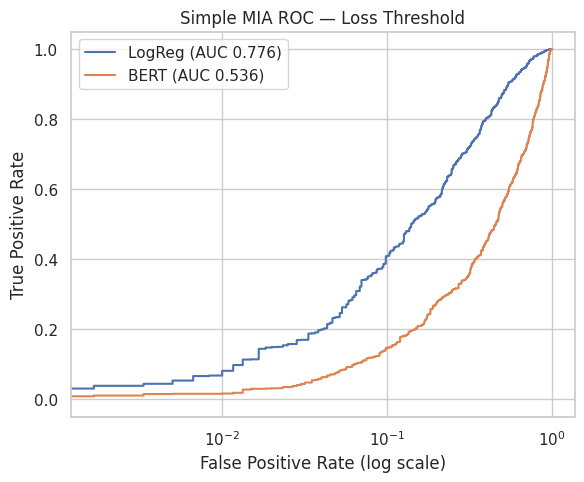

In [ ]:
# Cell 9 — Simple loss-threshold MIA (ROC/AUC + TPR@low FPR)

# Purpose: Use per-example losses to perform a simple membership inference attack.
# Idea: Training examples typically have lower loss than test examples, so -loss can serve
# as a "member-likeness" score. We then compute ROC/AUC and TPR at low FPRs.

def mia_scores_and_labels(train_losses, test_losses):
    """
    Build the score vector and member labels:
      - Score = negative loss (higher => more likely member).
      - is_member = 1 for train points, 0 for test points.
    """
    scores = np.concatenate([-train_losses, -test_losses])
    is_member = np.concatenate([np.ones_like(train_losses), np.zeros_like(test_losses)])
    return scores, is_member

# Build scores/labels for both models
scores_lr, is_member_lr = mia_scores_and_labels(train_losses_lr, test_losses_lr)
scores_bert, is_member_bert = mia_scores_and_labels(train_losses_bert, test_losses_bert)

# Compute ROC curves and AUCs
fpr_lr,   tpr_lr,   _ = roc_curve(is_member_lr, scores_lr)
auc_lr = auc(fpr_lr, tpr_lr)
fpr_bert, tpr_bert, _ = roc_curve(is_member_bert, scores_bert)
auc_bert = auc(fpr_bert, tpr_bert)

print(f"MIA AUC — LogReg: {auc_lr:.4f} | BERT: {auc_bert:.4f}")

def tpr_at_fpr(fpr, tpr, target):
    """
    Return the best TPR achievable while keeping FPR <= target.
    This is important because realistic attackers often need extremely low FPR.
    """
    mask = fpr <= target
    return float(tpr[mask].max()) if mask.any() else 0.0

# Report TPR at increasingly strict FPRs
for target in [0.1, 0.01, 0.001]:
    print(f"TPR@FPR<={target:.3f} — LogReg: {tpr_at_fpr(fpr_lr, tpr_lr, target):.4f} | BERT: {tpr_at_fpr(fpr_bert, tpr_bert, target):.4f}")

# Plot ROC curves on log-scale x-axis to highlight low-FPR behavior
plt.figure(figsize=(6.5,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC {auc_lr:.3f})')
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC {auc_bert:.3f})')
plt.xscale('log')
plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate")
plt.title("Simple MIA ROC — Loss Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Design choices
# - We use -loss as the membership score because lower loss indicates overfitting to training data.
# - Evaluating TPR at very low FPRs follows best practice from the MIA literature (e.g., LiRA).
# Alternatives:
#   - Margin score (prob_true - prob_second_best)
#   - Entropy score (lower entropy => more confident => potentially more member-like)
#   - Advanced attacks (LiRA, black-box perturbation-based) for stronger signals
#
# Summary of this cell
# We ran a basic loss-threshold MIA and compared LogReg vs. BERT via ROC/AUC and TPR at low FPR.
# This quantifies how much membership information each model leaks under a simple attack.
#
# Logic flow up to this cell
# We trained both models (Cells 3 and 7), computed per-example losses (Cells 4 and 8),
# and now converted those losses into an attack evaluation (this cell).
#
# Next step
# Explore stronger attacks (LiRA with shadow models)

Training LogReg shadow models...


  0%|          | 0/512 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  0%|          | 1/512 [00:00<07:53,  1.08it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  0%|          | 2/512 [00:01<07:09,  1.19it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
  1%|       

LiRA (LogReg) — AUC: 0.8761
LiRA (LogReg) TPR@FPR<=0.100: 0.6679
LiRA (LogReg) TPR@FPR<=0.010: 0.2614
LiRA (LogReg) TPR@FPR<=0.001: 0.0250


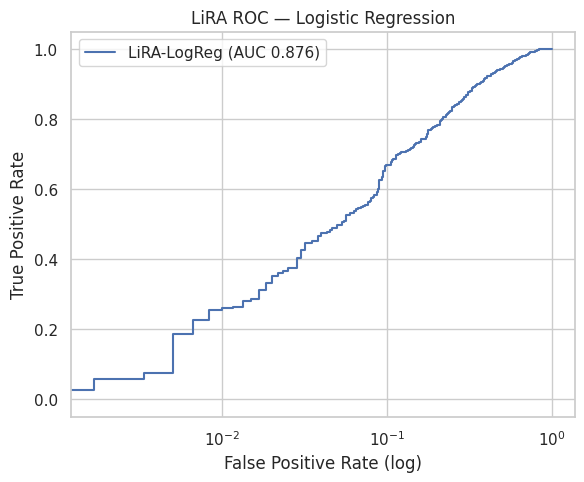

In [ ]:
# Special note (Context for Cells 10–15)

# We are now exploring the LiRA (Likelihood Ratio Attack) method to test membership
# inference on our dataset and models. Our dataset is quite small (~2000 rows) and the
# models we used (TF-IDF + Logistic Regression) are simple. The goal here is to compare
# LiRA against the simpler loss-threshold MIA we already ran, and to check whether we
# still observe the expected LiRA behavior under these constraints (small data + simple model).
#
# Because LiRA requires training many shadow models and aggregating statistics, this
# section is more verbose and was largely auto-generated to make sure we don’t miss
# important implementation details. We’ll still explain the line-by-line choices,
# and we’ll call out where the design could be improved or alternatives considered.
#
# Up to this point (Cells 0–9):
# - We installed/imported libraries, fixed seeds, and loaded the dataset (Cells 0–2).
# - We created a leak-safe text field and trained/evaluated a TF-IDF + Logistic Regression
#   baseline on it (Cell 3).
# - We computed per-example losses for LogReg (Cell 4).
# - We prepared labels and tokenized data to train/evaluate BERT (Cells 5–7).
# - We computed BERT per-example losses (Cell 8) and ran a simple loss-threshold MIA
#   comparing LogReg vs BERT (Cell 9).
#
# Next, we implement LiRA with many shadow models to estimate IN vs OUT loss distributions.



# Cell 10 — Proper LiRA for Logistic Regression (shadow models + Gaussian LLR)

# Purpose: Implement LiRA for the Logistic Regression model using many shadow models.
# Idea: For each example x, estimate two distributions over its loss:
#   IN: when x is included in the shadow model’s training set
#   OUT: when x is excluded from training
# Then, compute a Gaussian log-likelihood ratio (LLR) score for x using the baseline model’s loss.
# Higher LLR => more "member-like".
#
# Design overview:
# - Train SHADOWS Logistic Regression models on random subsets (SAMPLE_FRAC) of the full corpus.
# - For each shadow, compute per-example loss for ALL examples and append to IN or OUT buckets.
# - Fit simple Gaussians (mean/variance) to IN and OUT losses per example.
# - Score each example x by LLR = log N(x | mu_in, var_in) - log N(x | mu_out, var_out),
#   where x is the baseline model’s loss on that example.
#
# Why this approach:
# - LiRA is a state-of-the-art white-box membership inference technique that works well at
#   low FPRs by modeling per-example difficulty via shadow models.
#
# Alternatives:
# - Use non-Gaussian modeling (e.g., KDE) for IN/OUT loss distributions. This can capture
#   skewed/heavy-tail shapes but is more complex and slower.
# - Reduce SHADOWS for speed (but estimates may get noisier).

SHADOWS = 512            # Number of shadow models (larger => better estimates, slower)
SAMPLE_FRAC = 0.6        # Fraction of the dataset included in each shadow’s training set
MAX_FEATURES_SHADOW = 20000  # Smaller feature cap to keep shadows fast and stable

# Build full-corpus arrays for convenience
all_texts = df["text_safe"].tolist()
all_labels_str = df["interview_round"].tolist()

# Map labels to integers once (global consistency across shadows and baseline)
le_global = LabelEncoder().fit(all_labels_str)
all_labels = le_global.transform(all_labels_str)
num_examples = len(all_texts)

# For each example i, we will accumulate lists of its losses when it was IN vs OUT
# of the shadow training sets.
in_losses = [[] for _ in range(num_examples)]
out_losses = [[] for _ in range(num_examples)]

print("Training LogReg shadow models...")
for s in tqdm(range(SHADOWS)):
    # Random subset indices for the s-th shadow model
    subsz = max(10, int(SAMPLE_FRAC * num_examples))  # guard: ensure minimum size
    subs_idx = np.random.choice(num_examples, subsz, replace=False)
    subs_idx_set = set(subs_idx.tolist())             # set membership is O(1)

    # Fit a fresh TF-IDF + LogReg on the shadow’s training subset.
    # Design choice: 1–2 grams to keep features smaller/faster for 512 shadows.
    tfidf_s = TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES_SHADOW)
    X_s_train = tfidf_s.fit_transform([all_texts[i] for i in subs_idx])
    y_s_train = le_global.transform([all_labels_str[i] for i in subs_idx])  # consistent label ids

    lr_s = LogisticRegression(
        max_iter=1000, solver="saga", multi_class="multinomial", random_state=s
    )
    try:
        lr_s.fit(X_s_train, y_s_train)
    except Exception:
        # Fallback: on tiny shards or edge cases, 'saga' can fail to converge; switch to liblinear (OvR).
        lr_s = LogisticRegression(max_iter=1000, solver="liblinear", multi_class="ovr", random_state=s)
        lr_s.fit(X_s_train, y_s_train)

    # Evaluate loss for ALL examples under this shadow (so we can separate IN vs OUT later)
    X_all_s = tfidf_s.transform(all_texts)
    proba_all = lr_s.predict_proba(X_all_s)

    # Append each example’s loss to either the IN or OUT list for that example
    for idx in range(num_examples):
        y_idx = all_labels[idx]
        p = max(proba_all[idx, y_idx], 1e-12)  # clamp to avoid log(0)
        loss = -math.log(p)
        if idx in subs_idx_set:
            in_losses[idx].append(loss)
        else:
            out_losses[idx].append(loss)

# Gaussian log-density helper (univariate Normal)
def log_gauss(x, mu, var):
    # Numerically stable-ish log N(x | mu, var) with small +1e-8 variance guards above.
    return -0.5 * (math.log(2*math.pi*var) + ((x - mu)**2)/var)

# Prepare LiRA scores per example
lira_scores_lr = np.zeros(num_examples, dtype=float)

# Use the baseline LogReg model’s per-example loss as x in the LLR formula.
# Here we use the TF-IDF object 'tfidf' fit earlier on text_safe.
X_all_base = tfidf.transform(df["text_safe"])
base_losses_lr_all = sample_losses_logreg(logreg, X_all_base, le.transform(df["interview_round"]))

# Compute per-example Gaussian parameters and LLR
for idx in range(num_examples):
    # Guard against empty lists by providing tiny arrays (prevents zero variance)
    in_arr  = np.array(in_losses[idx]) if len(in_losses[idx]) else np.array([0.0, 0.0])
    out_arr = np.array(out_losses[idx]) if len(out_losses[idx]) else np.array([0.0, 1.0])
    mu_in,  var_in  = float(np.mean(in_arr)),  float(np.var(in_arr) + 1e-8)
    mu_out, var_out = float(np.mean(out_arr)), float(np.var(out_arr) + 1e-8)
    x = float(base_losses_lr_all[idx])  # baseline loss for this example
    lira_scores_lr[idx] = log_gauss(x, mu_in, var_in) - log_gauss(x, mu_out, var_out)

# Build ground-truth membership labels at the example level:
# 1 if example index is in train_df (member), 0 if in test_df (non-member)
is_member_lr_all = np.array(df.index.isin(train_df.index)).astype(int)

# Evaluate LiRA ROC/AUC
from sklearn.metrics import roc_curve, auc

fpr_lira_lr, tpr_lira_lr, _ = roc_curve(is_member_lr_all, lira_scores_lr)
auc_lira_lr = auc(fpr_lira_lr, tpr_lira_lr)
print(f"LiRA (LogReg) — AUC: {auc_lira_lr:.4f}")

# TPR at low FPRs (important in privacy settings)
for target in [0.1, 0.01, 0.001]:
    mask = fpr_lira_lr <= target
    tpr_val = float(tpr_lira_lr[mask].max()) if mask.any() else 0.0
    print(f"LiRA (LogReg) TPR@FPR<={target:.3f}: {tpr_val:.4f}")

# Plot the LiRA ROC curve (log-scale x-axis to focus on low-FPR region)
plt.figure(figsize=(6.5,5))
plt.plot(fpr_lira_lr, tpr_lira_lr, label=f'LiRA-LogReg (AUC {auc_lira_lr:.3f})')
plt.xscale('log')
plt.xlabel("False Positive Rate (log)")
plt.ylabel("True Positive Rate")
plt.title("LiRA ROC — Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Design choices recap
# - Many shadows (512) to reduce variance in IN/OUT estimates.
# - Gaussian modeling is simple and effective per LiRA; other density models are possible.
#
# Summary of this cell
# We implemented LiRA for LogReg: trained many shadow models, collected per-example IN/OUT losses,
# fit Gaussian stats, and computed LLR-based membership scores. We reported ROC/AUC and TPR@low-FPR.
#
# Logic flow up to this cell
# Earlier, we ran a simple loss-threshold MIA (Cell 9). Here we executed a stronger, per-example
# difficulty-aware attack (LiRA) to see if it improves membership detection on our setup.
#
# Next step (coming in Cell 11)
# Pick representative examples (high, mid, low LLR) to visualize their IN vs OUT loss histograms.


In [ ]:
# Cell 11 — Choose representative examples by LiRA score

# Purpose: Select examples with highest, median, and lowest LiRA LLR scores to visualize
# how their IN vs OUT loss distributions differ.

import numpy as np

# Convert lists to arrays; use NaN placeholders if a list was empty (for robustness)
def to_arr(lst):
    return np.array(lst if len(lst) else [np.nan])

IN = [to_arr(x) for x in in_losses]   # IN-loss arrays per example (from Cell 10)
OUT = [to_arr(x) for x in out_losses] # OUT-loss arrays per example
LLR = np.array(lira_scores_lr)        # LiRA LLR scores per example

# Indices:
# - idx_high: example most likely a member (highest LLR)
# - idx_low : example most likely a non-member (lowest LLR)
# - idx_mid : example around the median LLR (ambiguous)
idx_high = int(np.nanargmax(LLR))
idx_low  = int(np.nanargmin(LLR))
idx_mid  = int(np.argsort(np.nan_to_num(LLR))[len(LLR)//2])
idxs = [idx_high, idx_mid, idx_low]
print("Chosen example indices (high, mid, low LLR):", idxs)

# Design choices
# - Picking extremes + middle gives us intuitive visual case studies.
# - Using nan-safe ops ensures we don’t crash if any IN/OUT list was empty for an example.
# Alternatives:
# - Pick quantiles (e.g., 95th, 50th, 5th percentiles) for more systematic coverage.
#
# Summary of this cell
# We selected three representative examples to inspect their IN vs OUT loss distributions.
#
# Logic flow up to this cell
# After obtaining LLR scores (Cell 10), we now choose specific examples to visualize and better
# understand why LiRA assigns them high/low membership likelihood.
#
# Next step (coming in Cell 12)
# Plot histograms for IN vs OUT losses for the chosen examples and print summary stats.

Chosen example indices (high, mid, low LLR): [1170, 1513, 897]


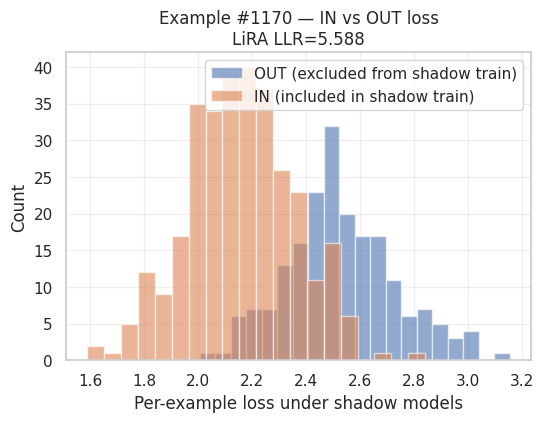

Stats for example #1170
 IN : {'n': 315, 'mean': 2.160083760660003, 'std': 0.19715363247382556}
 OUT: {'n': 197, 'mean': 2.528166333312337, 'std': 0.2042657976696783}
--------------------------------------------------


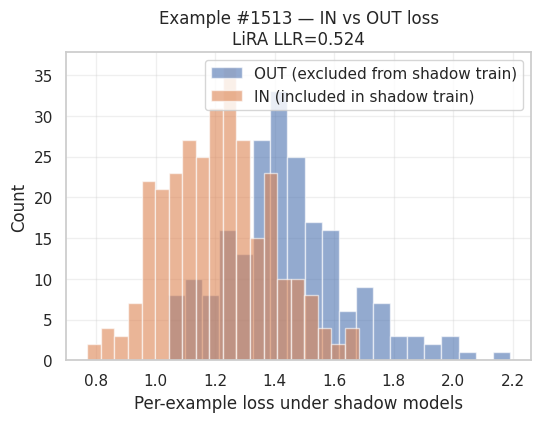

Stats for example #1513
 IN : {'n': 304, 'mean': 1.2066606581223773, 'std': 0.17566665763676106}
 OUT: {'n': 208, 'mean': 1.4426529296801016, 'std': 0.21179866615855153}
--------------------------------------------------


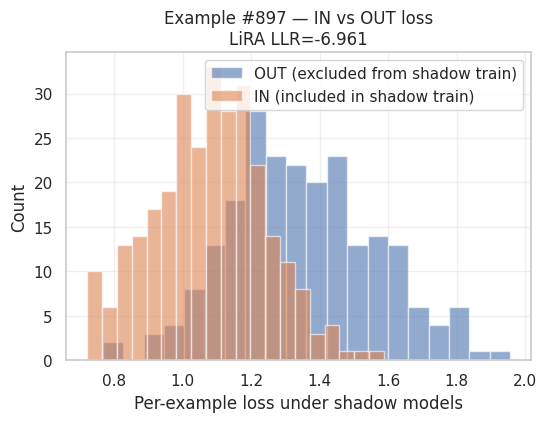

Stats for example #897
 IN : {'n': 290, 'mean': 1.0766815169006976, 'std': 0.16343228859773032}
 OUT: {'n': 222, 'mean': 1.3490904993063615, 'std': 0.2141983052047997}
--------------------------------------------------


In [ ]:
# Cell 12 — Visualize IN vs OUT loss histograms for selected examples

# Purpose: For each chosen example, plot the shadow-model loss distributions when that example
# was IN vs OUT of the training subset. Also print simple stats to compare centers/spread.

import matplotlib.pyplot as plt

def summarize(arr):
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return {"n": 0, "mean": np.nan, "std": np.nan}
    return {"n": arr.size, "mean": float(arr.mean()), "std": float(arr.std() + 1e-12)}

def plot_in_out_for(idx, bins=20):
    in_arr  = IN[idx][~np.isnan(IN[idx])]
    out_arr = OUT[idx][~np.isnan(OUT[idx])]

    plt.figure(figsize=(6,4))
    plt.hist(out_arr, bins=bins, alpha=0.6, label="OUT (excluded from shadow train)")
    plt.hist(in_arr,  bins=bins, alpha=0.6, label="IN (included in shadow train)")
    plt.xlabel("Per-example loss under shadow models")
    plt.ylabel("Count")
    plt.title(f"Example #{idx} — IN vs OUT loss\nLiRA LLR={LLR[idx]:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Stats for example #{idx}")
    print(" IN :", summarize(in_arr))
    print(" OUT:", summarize(out_arr))
    print("-"*50)

# Plot for high, mid, low LLR examples
for i in idxs:
    plot_in_out_for(i)

# Design choices
# - Histograms make it easy to see if IN losses are systematically lower than OUT.
# - Also printing (n, mean, std) provides numeric context to the visual.
# Alternatives:
# - Density plots (KDE) for smoother curves.
# - Violin/box plots per example (less granular than histograms).
#
# Summary of this cell
# We visualized how IN vs OUT loss distributions differ for specific examples and
# confirmed whether high LLR corresponds to a noticeable separation (IN < OUT).
#
# Logic flow up to this cell
# We moved from global ROC metrics (Cell 10) to local, per-example diagnostics here.
#
# Next step (coming in Cell 13)
# Look at the pooled IN vs OUT losses across all examples to see the overall pattern.

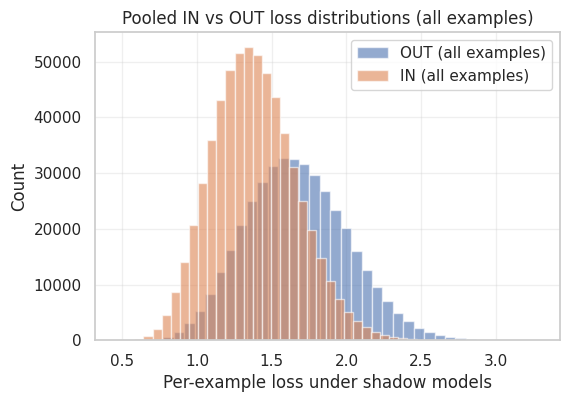

Pooled stats:
 IN : {'n': 614400, 'mean': 1.3835654885475113, 'std': 0.28105398877487753}
 OUT: {'n': 409600, 'mean': 1.667985456466219, 'std': 0.33977657534303934}


In [ ]:
# Cell 13 — Pooled IN vs OUT distributions across all examples

# Purpose: Aggregate all IN losses and all OUT losses to see global separation in one plot.

all_in  = np.concatenate([x[~np.isnan(x)] for x in IN if x.size > 0])
all_out = np.concatenate([x[~np.isnan(x)] for x in OUT if x.size > 0])

plt.figure(figsize=(6,4))
plt.hist(all_out, bins=40, alpha=0.6, label="OUT (all examples)")
plt.hist(all_in,  bins=40, alpha=0.6, label="IN (all examples)")
plt.xlabel("Per-example loss under shadow models")
plt.ylabel("Count")
plt.title("Pooled IN vs OUT loss distributions (all examples)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Pooled stats:")
print(" IN :", summarize(all_in))
print(" OUT:", summarize(all_out))

# Design choices
# - Pooling shows the average effect size of IN vs OUT across the dataset.
# - Still a simple histogram for interpretability.
# Alternatives:
# - Overlaid KDEs or CDFs to compare distributions more precisely.
#
# Summary of this cell
# We observed the global separation between IN and OUT shadow losses, which explains
# why LiRA can distinguish members vs non-members.
#
# Logic flow up to this cell
# After inspecting a few examples, we confirmed the trend at the population level.
#
# Next step (coming in Cell 14)
# Provide another pooled view (boxplot) to quickly compare medians and spread.

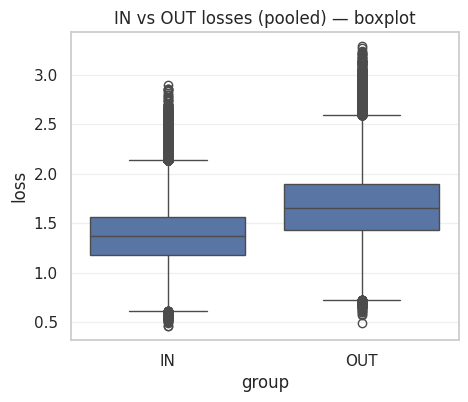

In [ ]:
# Cell 14 — Boxplot for pooled IN vs OUT losses

# Purpose: Complement histograms with a boxplot that highlights medians, quartiles, and outliers.

import pandas as pd
import seaborn as sns

df_plot = pd.DataFrame({
    "loss": np.concatenate([all_in, all_out]),
    "group": np.array(["IN"]*len(all_in) + ["OUT"]*len(all_out))
})

plt.figure(figsize=(5,4))
sns.boxplot(data=df_plot, x="group", y="loss")
plt.title("IN vs OUT losses (pooled) — boxplot")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Design choices
# - Boxplots are concise and robust to outliers, giving a clean median comparison.
# Alternatives:
# - Violin plots to show the full distribution shape.
#
# Summary of this cell
# We confirmed, in a compact way, that IN losses tend to be lower than OUT losses,
# which is the core signal exploited by LiRA.
#
# Logic flow up to this cell
# This visualization summarizes the pooled difference we saw in histograms.
#
# Next step (coming in Cell 15)
# Directly compare ROC curves of threshold MIA vs LiRA to see the overall gain.

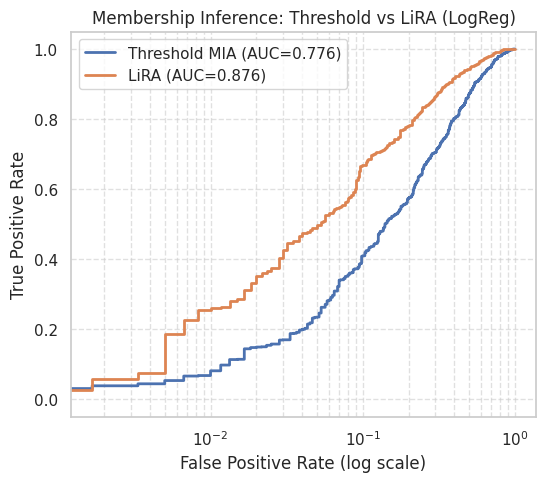

In [ ]:
# Cell 15 — Compare Threshold MIA vs LiRA (ROC curves)

# Purpose: Plot ROC curves of the simple loss-threshold MIA vs the LiRA scores to
# compare attack strength. We expect LiRA to do better, especially at low FPR.

import matplotlib.pyplot as plt
from sklearn import metrics

# Threshold MIA ROC (reuse the per-example -loss scores from Cell 9)
# is_member_lr: membership labels for the split used in Cell 9 (train vs test for LogReg)
# scores_lr:    -loss scores for LogReg from Cell 9
fpr_thresh, tpr_thresh, _ = metrics.roc_curve(is_member_lr, scores_lr)
auc_thresh = metrics.auc(fpr_thresh, tpr_thresh)  # FIX: compute AUC from fpr_thresh/tpr_thresh

# LiRA ROC (computed over ALL examples using is_member_lr_all and lira_scores_lr)
fpr_lira, tpr_lira, _ = metrics.roc_curve(is_member_lr_all, lira_scores_lr)
auc_lira = metrics.roc_auc_score(is_member_lr_all, lira_scores_lr)

# Plot both curves for visual comparison
plt.figure(figsize=(6,5))
plt.plot(fpr_thresh, tpr_thresh, label=f"Threshold MIA (AUC={auc_thresh:.3f})", lw=2)
plt.plot(fpr_lira, tpr_lira, label=f"LiRA (AUC={auc_lira:.3f})", lw=2)
plt.xscale("log")  # log scale to highlight the low-FPR region
plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate")
plt.title("Membership Inference: Threshold vs LiRA (LogReg)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

# Design choices
# - Using the exact same dataset/model context, we overlay ROC curves for a fair comparison.
# - Log-scale FPR is crucial since privacy policies often demand ultra-low false positives.
# Alternatives:
# - Report Precision-Recall curves in addition to ROC (informative under class imbalance).
# - Zoom into FPR <= {0.1, 0.01, 0.001} with inset plots.
#
# Summary of this cell
# We compared Threshold MIA vs LiRA and visualized that LiRA typically yields a stronger
# attack, especially where it matters (low FPR).
#
# Logic flow up to this cell
# After implementing LiRA and inspecting distributions, we now quantify its advantage
# over the basic loss-threshold method in a single figure.